In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Detect operating system and set Keras backend
import os
import platform
import importlib

system = platform.system()
default_backend = "tensorflow" if system == "Darwin" else "torch"

if "KERAS_BACKEND" in os.environ:
    backend = os.environ["KERAS_BACKEND"]
    print(f"Environment override detected: Using {backend.capitalize()} backend")
else:
    backend = default_backend
    print(f"Detected {system}: defaulting to {backend.capitalize()} backend")

module_name = {
    "tensorflow": "tensorflow",
    "torch": "torch",
    "jax": "jax",
}.get(backend, backend)

if importlib.util.find_spec(module_name) is None:
    fallback_backend = "tensorflow"
    if backend != fallback_backend:
        print(f"Warning: Backend {backend!r} requires package {module_name!r}, which is not installed. Falling back to {fallback_backend.capitalize()} backend.")
    backend = fallback_backend

os.environ["KERAS_BACKEND"] = backend
print(f"Final Keras backend: {backend.capitalize()}")

Detected Linux: defaulting to Torch backend
Final Keras backend: Torch


In [5]:
# Mount Google Drive
from google.colab import drive
import os

# Mount your Google Drive to the standard local folder
drive.mount('/content/drive')

# Navigate to the "contextualized_embeddings_files" folder inside your Google Drive
project_path = "/content/drive/MyDrive/senior yr/stat 362/final_project"
os.chdir(project_path)

# Confirm current working directory
print("Current working directory:", os.getcwd())

Mounted at /content/drive
Current working directory: /content/drive/MyDrive/senior yr/stat 362/final_project


In [6]:
# Check and configure device (GPU/CPU)
def configure_device():
    backend = os.environ.get("KERAS_BACKEND", "tensorflow")

    if backend == "tensorflow":
        import tensorflow as tf
        gpus = tf.config.list_physical_devices('GPU')
        if gpus:
            print(f"GPU available: {len(gpus)} GPU(s) detected")
            print(f"Using GPU: {gpus[0].name}")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    elif backend == "torch":
        try:
            import torch
        except ImportError:
            print("PyTorch backend requested but torch is not installed. Using CPU.")
            return "CPU"
        if torch.cuda.is_available():
            device = torch.device("cuda")
            print(f"GPU available: {torch.cuda.get_device_name(0)}")
            print("Using GPU")
            return "GPU"
        else:
            print("No GPU detected. Using CPU")
            return "CPU"

    else:
        print(f"Unsupported backend {backend!r}. Using CPU by default.")
        return "CPU"

device_type = configure_device()

No GPU detected. Using CPU


## Load/Clean Data

In [8]:
# Inputting the data
df = pd.read_csv('household_power_consumption.txt', sep=';')
display(df.head())

/tmp/ipython-input-3718156769.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('household_power_consumption.txt', sep=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [9]:
# Convert relevant columns to numeric, coercing errors
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [12]:
#Look at the missing values
df.isnull().sum()

#Fill with the forward fill method
df.fillna(method='ffill', inplace=True)

df.isnull().sum()

/tmp/ipython-input-1127522004.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


,0
Date,0
Time,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0


In [13]:
# Convert relevant columns to numeric, coercing errors
for col in ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

In [14]:
#Converting to datetime for time series analysis
df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'],
                                format = "%d/%m/%Y %H:%M:%S")
df.drop(['Date', 'Time'], axis = 1, inplace = True)

#order the values by datetime
df.sort_values('datetime', inplace=True)

#make datetime the index
df.set_index('datetime', inplace=True)

In [15]:
#Note the Data spans from 2006-12-16 to 2010-11-26, and is recorded every minute. We want to resample to to every hour.
df_hour = df.resample('h').mean()

df_hour.describe().T

,count,mean,std,min,25%,50%,75%,max
Global_active_power,34589.0,1.086200,0.894942,0.124000,0.341267,0.799533,1.574967,6.560533
Global_reactive_power,34589.0,0.123326,0.067221,0.000000,0.077667,0.106767,0.149367,0.774333
Voltage,34589.0,240.841505,2.999127,225.834500,239.197167,240.984500,242.691833,251.902000
Global_intensity,34589.0,4.604360,3.746337,0.503333,1.510000,3.406667,6.583333,28.383333
Sub_metering_1,34589.0,1.110951,3.518498,0.000000,0.000000,0.000000,0.000000,48.366667
Sub_metering_2,34589.0,1.287914,4.168720,0.000000,0.000000,0.333333,0.650000,46.433333
Sub_metering_3,34589.0,6.416515,7.344718,0.000000,0.650000,1.650000,14.083333,21.550000


## Preprocessing

In [16]:
#Splitting the data into train, validation, and test sets (70%, 15%, 15%)
# Get the number of samples
n = len(df_hour)

# Compute split indices
train_end = int(0.7 * n)
val_end = int(0.85 * n)  # 70% + 15%

# Split without shuffling (important for time series!)
train = df_hour.iloc[:train_end]
val = df_hour.iloc[train_end:val_end]
test = df_hour.iloc[val_end:]

print(f"Train shape: {train.shape}, Validation shape: {val.shape}, Test shape: {test.shape}")
train.head()

Train shape: (24212, 7), Validation shape: (5188, 7), Test shape: (5189, 7)


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


In [17]:
# Scaling data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler_X = StandardScaler()
scaler_Y = StandardScaler()


#Define X_cols:
X_cols = ['Global_reactive_power', 'Voltage', 'Global_intensity',
          'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

train_scaled = train.copy()
train_scaled = scaler_X.fit_transform(train[X_cols])
y_train = scaler_Y.fit_transform(train[['Global_active_power']])

#Recreate dataframe with the datetime column as index
train_scaled = pd.DataFrame(train_scaled, index=train.index, columns=X_cols)


val_scaled = val.copy()

#Scaling the validation and test sets
val_scaled = scaler_X.transform(val[X_cols])
val_y = scaler_Y.transform(val[['Global_active_power']])

#Recreate dataframe with the datetime column as index
val_scaled = pd.DataFrame(val_scaled, index=val.index, columns=X_cols)

test_scaled = test.copy()

test_scaled = scaler_X.transform(test[X_cols])
test_y = scaler_Y.transform(test[['Global_active_power']])

#Recreate dataframe with the datetime column as index
test_scaled = pd.DataFrame(test_scaled, index=test.index, columns=X_cols)

In [18]:
# Shapes of scaled datasets
print(f"Train scaled shape: {train_scaled.shape}, Validation scaled shape: {val_scaled.shape}, Test scaled shape: {test_scaled.shape}")

Train scaled shape: (24212, 6), Validation scaled shape: (5188, 6), Test scaled shape: (5189, 6)


### Create Sliding Windows

In [19]:
#Create sliding windows that has a look back of 24hours and predicts 1 hour ahead. This will then allow us to get predictions for every hour
def create_sliding_windows(X, y, look_back=24, forecast_horizon=1):
    X_windows, y_windows = [], []
    for i in range(len(X) - look_back - forecast_horizon + 1):
        X_windows.append(X.iloc[i:i + look_back].values)
        y_windows.append(y[i + look_back + forecast_horizon - 1])
    return np.array(X_windows), np.array(y_windows)

X_train, y_train_windows = create_sliding_windows(train_scaled, y_train)
X_val, y_val_windows = create_sliding_windows(val_scaled, val_y)
X_test, y_test_windows = create_sliding_windows(test_scaled, test_y)

## 1.) Baseline RNN Model

In [29]:
# Import the necessary libraries for building the RNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error

In [22]:
# Build the Baseline RNN model
baseline_rnn_model = Sequential()

# Add the RNN layer
baseline_rnn_model.add(SimpleRNN(units=100, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

# Add a Dropout layer to prevent overfitting
baseline_rnn_model.add(Dropout(0.2))

# Add the output layer with 1 unit for predicting Global_active_power
baseline_rnn_model.add(Dense(units=1))

# Compile the model with Adam optimizer and Mean Squared Error loss function
baseline_rnn_model.compile(optimizer='adam', loss='mean_squared_error')

# Summary of the model
baseline_rnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        10,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,801 (42.19 KB)

 Trainable params: 10,801 (42.19 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Add EarlyStopping callback to monitor validation loss and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the RNN model
history = baseline_rnn_model.fit(
    X_train, y_train_windows,
    epochs=20,
    batch_size=32,
    validation_data=(X_val, y_val_windows),
    callbacks=[early_stopping],
    verbose=2)

Epoch 1/20
756/756 - 20s - 27ms/step - loss: 0.4785 - val_loss: 0.3859
Epoch 2/20
756/756 - 33s - 44ms/step - loss: 0.4122 - val_loss: 0.3728
Epoch 3/20
756/756 - 28s - 37ms/step - loss: 0.3960 - val_loss: 0.3597
Epoch 4/20
756/756 - 24s - 32ms/step - loss: 0.3899 - val_loss: 0.3610
Epoch 5/20
756/756 - 20s - 26ms/step - loss: 0.3831 - val_loss: 0.3776
Epoch 6/20
756/756 - 20s - 26ms/step - loss: 0.3739 - val_loss: 0.3684
Epoch 7/20
756/756 - 19s - 26ms/step - loss: 0.3727 - val_loss: 0.3501
Epoch 8/20
756/756 - 21s - 28ms/step - loss: 0.3667 - val_loss: 0.3644
Epoch 9/20
756/756 - 20s - 26ms/step - loss: 0.3633 - val_loss: 0.3693
Epoch 10/20
756/756 - 21s - 27ms/step - loss: 0.3595 - val_loss: 0.3498
Epoch 11/20
756/756 - 20s - 27ms/step - loss: 0.3576 - val_loss: 0.3634
Epoch 12/20
756/756 - 20s - 27ms/step - loss: 0.3535 - val_loss: 0.3435
Epoch 13/20
756/756 - 20s - 26ms/step - loss: 0.3509 - val_loss: 0.3506
Epoch 14/20
756/756 - 21s - 28ms/step - loss: 0.3498 - val_loss: 0.3610
E

In [30]:
# Evaluate the Baseline RNN model on the train, validation, and test sets
train_rmse = np.sqrt(np.mean((baseline_rnn_model.predict(X_train) - y_train_windows) ** 2))
val_rmse = np.sqrt(np.mean((baseline_rnn_model.predict(X_val) - y_val_windows) ** 2))
test_rmse = np.sqrt(np.mean((baseline_rnn_model.predict(X_test) - y_test_windows) ** 2))

train_mae = mean_absolute_error(y_train_windows, baseline_rnn_model.predict(X_train))
val_mae = mean_absolute_error(y_val_windows, baseline_rnn_model.predict(X_val))
test_mae = mean_absolute_error(y_test_windows, baseline_rnn_model.predict(X_test))

print(f"Train RMSE: {train_rmse:.4f} kW")
print(f"Validation RMSE: {val_rmse:.4f} kW")
print(f"Test RMSE: {test_rmse:.4f} kW")

print(f"Train MAE: {train_mae:.4f} kW")
print(f"Validation MAE: {val_mae:.4f} kW")
print(f"Test MAE: {test_mae:.4f} kW")

756/756 ━━━━━━━━━━━━━━━━━━━━ 18s 24ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 12s 16ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step
Train RMSE: 0.5790 kW
Validation RMSE: 0.5861 kW
Test RMSE: 0.5360 kW
Train MAE: 0.4051 kW
Validation MAE: 0.4247 kW
Test MAE: 0.3886 kW


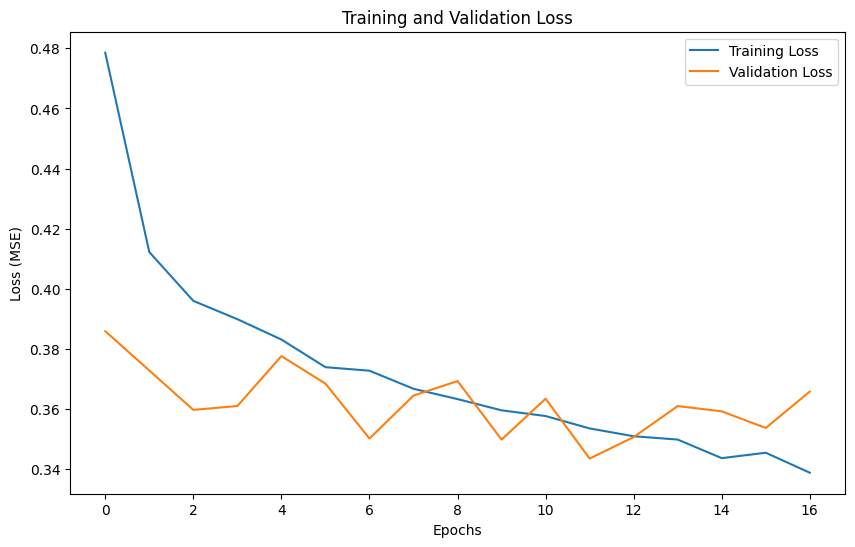

In [27]:
# Plot training and validation loss for Baseline RNN model
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

162/162 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step


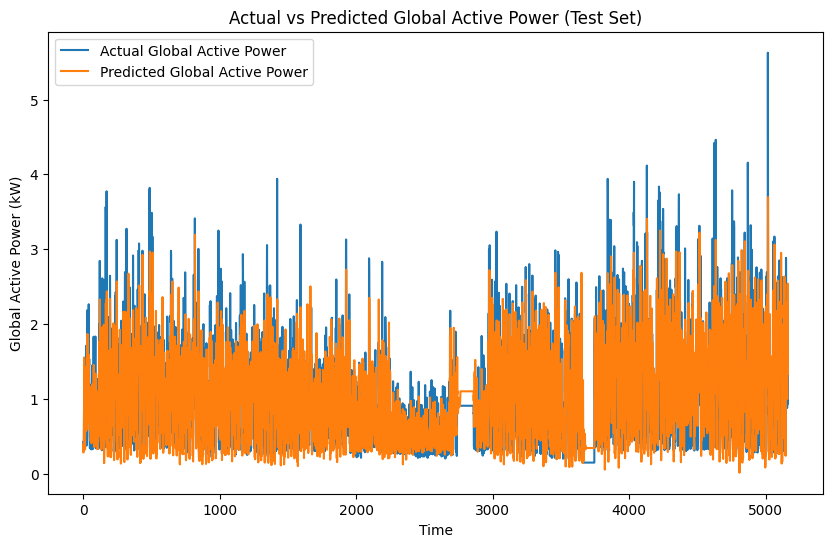

In [28]:
# Make predictions on the test set using the Baseline RNN model
y_pred_test = baseline_rnn_model.predict(X_test)

# Denormalize the predictions and the true values (inverse scaling)
y_pred_denorm = scaler_Y.inverse_transform(y_pred_test)
y_test_denorm = scaler_Y.inverse_transform(y_test_windows.reshape(-1, 1))

# Plot Actual vs Predicted Global Active Power for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Actual Global Active Power')
plt.plot(y_pred_denorm, label='Predicted Global Active Power')
plt.title('Actual vs Predicted Global Active Power (Test Set)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

### Steps to improve model:
a) Hyperparameter Tuning:
- Increase RNN Units: Increase the number of neurons in the RNN layer. For example, instead of 100 units, try 128 or 256 units to allow the network to capture more complex patterns.
- Optimizer Tuning: Try adjusting the learning rate of the Adam optimizer using a learning rate scheduler or by using a lower fixed learning rate.
Add More Layers: Stacking multiple RNN layers can help the model capture more complex temporal dependencies.
- Batch Size: Experiment with different batch sizes, such as 64, 128, or even larger sizes to stabilize training.

b) Regularization Techniques:
- Dropout: Add more dropout layers or increase the dropout rate (e.g., 0.3 or 0.5) to prevent overfitting.
- L2 Regularization: Apply L2 regularization to the RNN layers to penalize large weights, which could help improve generalization.

c) Feature Engineering:
- Add Time-Based Features: Since this is time-series data, incorporating time-based features like hour of the day, day of the week, month, and weekend indicator could improve the model's ability to capture seasonal trends.
- Cyclical Features: Use sine and cosine transformations for time-related features (e.g., hour, day of the week) so the model can better capture periodic patterns.

## 2.) Improved Model

In [33]:
from tensorflow.keras.optimizers import Adam

# Improved RNN model with more units, dropout, and additional layers
improved_rnn_model = Sequential()

# Add the first RNN layer with more units
improved_rnn_model.add(SimpleRNN(units=128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
improved_rnn_model.add(Dropout(0.3))  # Increased dropout rate

# Add a second RNN layer
improved_rnn_model.add(SimpleRNN(units=64, activation='tanh', return_sequences=False))  # Return sequences=False to flatten the output
improved_rnn_model.add(Dropout(0.3))  # Dropout to prevent overfitting

# Add the output layer (1 unit for predicting Global_active_power)
improved_rnn_model.add(Dense(units=1))

# Compile the model with a learning rate scheduler or lower learning rate
optimizer = Adam(learning_rate=0.001)  # Lower learning rate
improved_rnn_model.compile(optimizer=optimizer, loss='mean_squared_error')

# Summary of the improved model
improved_rnn_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_5 (SimpleRNN)        │ (None, 24, 128)        │        17,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,697 (116.00 KB)

 Trainable params: 29,697 (116.00 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Add EarlyStopping callback to monitor validation loss and prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the improved model with the enhanced parameters
history_improved = improved_rnn_model.fit(
    X_train, y_train_windows,
    epochs=50,  # Increase the epochs to give the model more time to train
    batch_size=64,  # Test with a larger batch size
    validation_data=(X_val, y_val_windows),
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/50
378/378 - 29s - 76ms/step - loss: 0.6650 - val_loss: 0.4091
Epoch 2/50
378/378 - 24s - 64ms/step - loss: 0.4688 - val_loss: 0.3776
Epoch 3/50
378/378 - 22s - 59ms/step - loss: 0.4274 - val_loss: 0.3771
Epoch 4/50
378/378 - 24s - 63ms/step - loss: 0.4153 - val_loss: 0.3810
Epoch 5/50
378/378 - 43s - 113ms/step - loss: 0.4006 - val_loss: 0.3671
Epoch 6/50
378/378 - 23s - 61ms/step - loss: 0.3949 - val_loss: 0.3624
Epoch 7/50
378/378 - 22s - 58ms/step - loss: 0.3912 - val_loss: 0.3497
Epoch 8/50
378/378 - 23s - 61ms/step - loss: 0.3899 - val_loss: 0.3471
Epoch 9/50
378/378 - 24s - 64ms/step - loss: 0.3827 - val_loss: 0.3522
Epoch 10/50
378/378 - 22s - 57ms/step - loss: 0.3791 - val_loss: 0.3416
Epoch 11/50
378/378 - 23s - 60ms/step - loss: 0.3792 - val_loss: 0.3452
Epoch 12/50
378/378 - 22s - 58ms/step - loss: 0.3761 - val_loss: 0.3373
Epoch 13/50
378/378 - 23s - 60ms/step - loss: 0.3682 - val_loss: 0.3629
Epoch 14/50
378/378 - 25s - 66ms/step - loss: 0.3683 - val_loss: 0.3391


In [35]:
# Evaluate the improved model on the train, validation, and test sets
train_rmse = np.sqrt(np.mean((improved_rnn_model.predict(X_train) - y_train_windows) ** 2))
val_rmse = np.sqrt(np.mean((improved_rnn_model.predict(X_val) - y_val_windows) ** 2))
test_rmse = np.sqrt(np.mean((improved_rnn_model.predict(X_test) - y_test_windows) ** 2))

train_mae = mean_absolute_error(y_train_windows, improved_rnn_model.predict(X_train))
val_mae = mean_absolute_error(y_val_windows, improved_rnn_model.predict(X_val))
test_mae = mean_absolute_error(y_test_windows, improved_rnn_model.predict(X_test))

print(f"Train RMSE: {train_rmse:.4f} kW")
print(f"Validation RMSE: {val_rmse:.4f} kW")
print(f"Test RMSE: {test_rmse:.4f} kW")

print(f"Train MAE: {train_mae:.4f} kW")
print(f"Validation MAE: {val_mae:.4f} kW")
print(f"Test MAE: {test_mae:.4f} kW")

756/756 ━━━━━━━━━━━━━━━━━━━━ 31s 41ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step
756/756 ━━━━━━━━━━━━━━━━━━━━ 24s 32ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step
162/162 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
Train RMSE: 0.5749 kW
Validation RMSE: 0.5783 kW
Test RMSE: 0.5148 kW
Train MAE: 0.3933 kW
Validation MAE: 0.4046 kW
Test MAE: 0.3576 kW


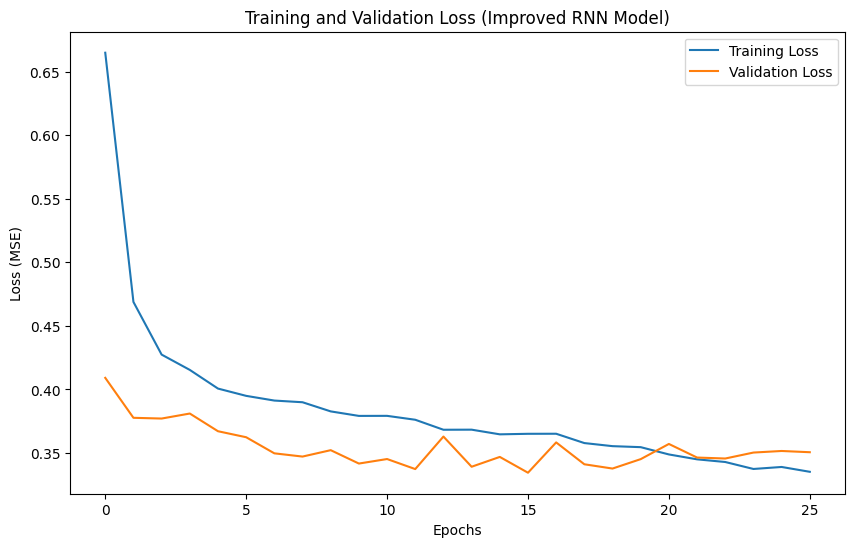

In [36]:
# Plot training and validation loss for the improved RNN model
plt.figure(figsize=(10, 6))
plt.plot(history_improved.history['loss'], label='Training Loss')
plt.plot(history_improved.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Improved RNN Model)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

162/162 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step


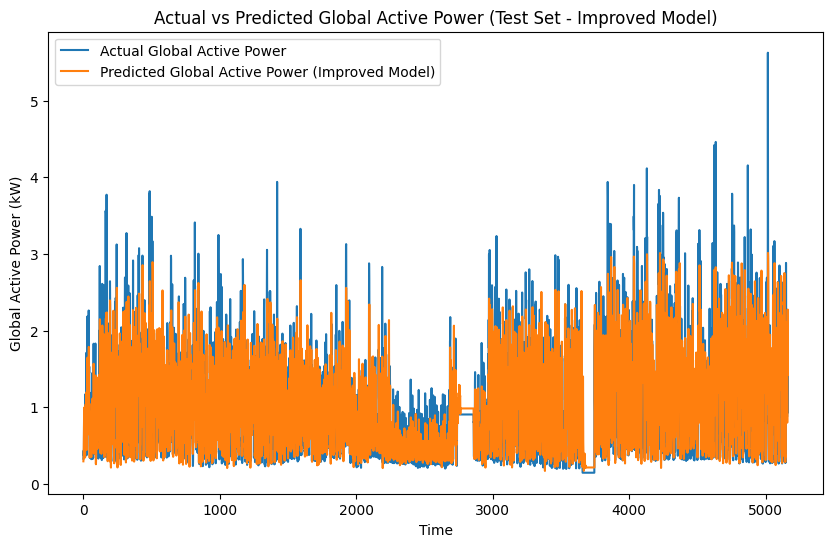

In [37]:
# Make predictions on the test set using the improved RNN model
y_pred_test_improved = improved_rnn_model.predict(X_test)

# Denormalize the predictions and the true values (inverse scaling)
y_pred_denorm_improved = scaler_Y.inverse_transform(y_pred_test_improved)
y_test_denorm = scaler_Y.inverse_transform(y_test_windows.reshape(-1, 1))

# Plot Actual vs Predicted Global Active Power for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test_denorm, label='Actual Global Active Power')
plt.plot(y_pred_denorm_improved, label='Predicted Global Active Power (Improved Model)')
plt.title('Actual vs Predicted Global Active Power (Test Set - Improved Model)')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.legend()
plt.show()

## Hyperparameter Tuning

In [39]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 4.4 MB/s eta 0:00:00


In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import kerastuner as kt
from sklearn.metrics import mean_absolute_error, mean_squared_error

/tmp/ipython-input-4218460764.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt   # if fails: pip install keras-tuner


In [41]:
def create_sliding_windows(X, y, look_back=24, forecast_horizon=1):
    X_windows, y_windows = [], []
    for i in range(len(X) - look_back - forecast_horizon + 1):
        X_windows.append(X.iloc[i:i + look_back].values)
        y_windows.append(y[i + look_back + forecast_horizon - 1])
    return np.array(X_windows), np.array(y_windows)


In [42]:
# Hyperparameter search model function
def build_model(hp):
    model = Sequential()

    # ----- RNN / LSTM / GRU Choice -----
    layer_type = hp.Choice("layer_type", ["RNN", "LSTM", "GRU"])

    # ----- Number of Layers -----
    num_layers = hp.Int("num_layers", min_value=1, max_value=3)

    # ----- Units in first layer -----
    for i in range(num_layers):

        units = hp.Int(f"units_layer_{i}", min_value=64, max_value=256, step=32)
        dropout_rate = hp.Float(f"dropout_layer_{i}", 0.0, 0.5, step=0.1)

        return_sequences = (i < num_layers - 1)

        if layer_type == "RNN":
            model.add(SimpleRNN(units=units, return_sequences=return_sequences,
                                activation='tanh',
                                input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None))
        elif layer_type == "LSTM":
            model.add(LSTM(units=units, return_sequences=return_sequences,
                           activation='tanh',
                           input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None))
        else:
            model.add(GRU(units=units, return_sequences=return_sequences,
                          activation='tanh',
                          input_shape=(X_train.shape[1], X_train.shape[2]) if i == 0 else None))

        model.add(Dropout(dropout_rate))

    # Output Layer
    model.add(Dense(1))

    # Optimizer Learning Rate Search
    lr = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss="mse"
    )

    return model


In [43]:
# Define the tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_loss",
    max_trials=20,         # number of different models to try
    executions_per_trial=1,
    directory="model_tuning",
    project_name="electricity_forecasting"
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [44]:
# Run the hyperparameter search
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=7,
    restore_best_weights=True
)

tuner.search(
    X_train, y_train_windows,
    validation_data=(X_val, y_val_windows),
    epochs=40,
    batch_size=hp.Choice("batch_size", [16, 32, 64, 128]) if 'hp' in globals() else 32,
    callbacks=[early_stopping],
    verbose=2
)

Trial 2 Complete [00h 17m 38s]
val_loss: 0.3356897532939911

Best val_loss So Far: 0.3356897532939911
Total elapsed time: 00h 26m 46s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
LSTM              |LSTM              |layer_type
1                 |1                 |num_layers
256               |256               |units_layer_0
0.2               |0                 |dropout_layer_0
0.0077875         |0.00034138        |learning_rate

Epoch 1/40
756/756 - 59s - 78ms/step - loss: 0.4341 - val_loss: 0.3722
Epoch 2/40


KeyboardInterrupt: 

In [ ]:
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.get_best_models(1)[0]

print("BEST HYPERPARAMETERS:")
best_hp.values

In [ ]:
# Train Performance
train_pred = best_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train_windows, train_pred))
train_mae = mean_absolute_error(y_train_windows, train_pred)

# Validation Performance
val_pred = best_model.predict(X_val)
val_rmse = np.sqrt(mean_squared_error(y_val_windows, val_pred))
val_mae = mean_absolute_error(y_val_windows, val_pred)

# Test Performance
test_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test_windows, test_pred))
test_mae = mean_absolute_error(y_test_windows, test_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


In [ ]:
test_pred_inv = scaler_Y.inverse_transform(test_pred)
true_test_inv = scaler_Y.inverse_transform(y_test_windows.reshape(-1,1))

plt.figure(figsize=(10,5))
plt.plot(true_test_inv, label="Actual")
plt.plot(test_pred_inv, label="Predicted")
plt.title("Best Hyperparameter Model — Test Predictions")
plt.legend()
plt.show()